In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_base import evaluate_build, focus_build

In [17]:
fname               = 'F25_Linear-LSTM128x4-FC-SELU-FC'
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 100
batch_size_second   = 500
evaluate_num        = 128
focus_min           = 0.6

In [3]:
class net_test(torch.nn.Module):
    def __init__(self, **kwargs):
        super(net_test, self).__init__()
        self.embedding = torch.nn.Linear(25, 128, bias=False)
        self.lstm = torch.nn.LSTM(128, 128, num_layers=4, bias=False, bidirectional=True, batch_first=True)
        self.fc1 = torch.nn.Linear(128*2, 32, bias=False)
        self.selu = nn.SELU()
        self.fc2 = torch.nn.Linear(32, 1, bias=True)
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

data_train_df = add_features(data_train_df)
data_test_df = add_features(data_test_df)

In [6]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [7]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [8]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

In [9]:
x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

In [10]:
del data_train_df
del data_test_df
gc.collect()

0

In [11]:
model = net_test()
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

net_test(
  (embedding): Linear(in_features=25, out_features=128, bias=False)
  (lstm): LSTM(128, 128, num_layers=4, bias=False, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=32, bias=False)
  (selu): SELU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
1453217 0


epoch,train_loss,valid_loss,time
0,2.339891,1.996804,00:25
1,1.236214,1.183142,00:25
2,1.152734,1.085907,00:27
3,1.041418,1.104860,00:28
4,1.010970,1.128485,00:27
5,0.969865,0.964576,00:27
6,0.920891,0.967847,00:28
7,0.864065,0.745896,00:27
8,0.762336,0.755712,00:26
9,0.804679,0.756590,00:25


Epoch 11: reducing lr to 9.795217472526449e-05
Epoch 24: reducing lr to 0.0001999999979225561
Epoch 34: reducing lr to 0.00019135745101272935
Epoch 44: reducing lr to 0.00016691854379352361
Epoch 54: reducing lr to 0.0001309089866847191
Epoch 64: reducing lr to 8.955513989290548e-05
Epoch 74: reducing lr to 5.00075110245173e-05
Epoch 84: reducing lr to 1.9104179931059522e-05
Epoch 94: reducing lr to 2.1886624206054943e-06


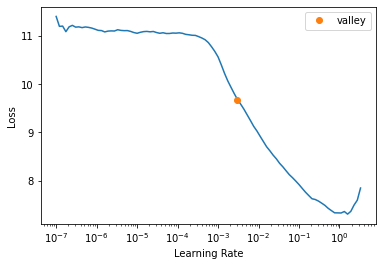

In [12]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_first)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_first, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))

epoch,train_loss,valid_loss,time
0,0.160217,0.201269,00:19
1,0.160485,0.201247,00:19
2,0.160573,0.201285,00:19
3,0.161427,0.201980,00:19
4,0.161709,0.201726,00:19
5,0.162804,0.202146,00:19
6,0.163662,0.202686,00:19
7,0.165564,0.202465,00:19
8,0.167243,0.208908,00:19
9,0.169268,0.210167,00:19


Better model found at epoch 0 with valid_loss value: 0.2012692242860794.
Better model found at epoch 1 with valid_loss value: 0.20124748349189758.
Epoch 10: reducing lr to 8.591347194839051e-05
Epoch 20: reducing lr to 0.00018807736282679062
Epoch 30: reducing lr to 0.00019686695046697975
Epoch 40: reducing lr to 0.0001783910593204253
Epoch 50: reducing lr to 0.00014636080449597928
Better model found at epoch 55 with valid_loss value: 0.20104087889194489.
Epoch 60: reducing lr to 0.00010631454665746575
Better model found at epoch 61 with valid_loss value: 0.19715256989002228.
Better model found at epoch 62 with valid_loss value: 0.19648578763008118.
Better model found at epoch 63 with valid_loss value: 0.1954515129327774.
Better model found at epoch 64 with valid_loss value: 0.1951247751712799.
Better model found at epoch 65 with valid_loss value: 0.19453994929790497.
Better model found at epoch 67 with valid_loss value: 0.19417564570903778.
Better model found at epoch 68 with valid_lo

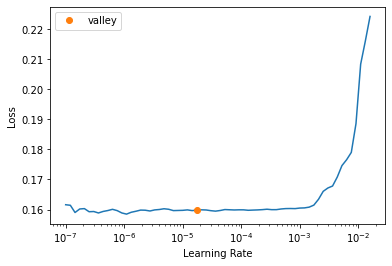

In [13]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_second)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_second, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                        SaveModelCallback(monitor='valid_loss', fname=f'{fname}_best')])

In [14]:
from HW_torch import torch_valid, torch_predict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load(f'models/{fname}_best.pth')
model.load_state_dict(state_dict)

loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size_second, to_device=device)
valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size_second, to_device=device)

print(loss, valid_loss)

0.13377549160610547 0.18834879850187608


In [15]:
predict = torch_predict([model.to(device)], x_test, batch_size_second, to_device=device)
predict = np.reshape(predict, (-1))

prodict: 100% 101/101 [00:04<00:00, 20.30it/s]


In [18]:
df = pd.read_csv('Database/sample_submission.csv', index_col=0)
df['pressure'] = predict

df.to_csv(f'Submission/{fname}.csv')